In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from graph import Graph
from airports import construct_airports
import geopandas as gpd
from collections import defaultdict
import time
import seaborn as sns

# Funções auxiliares


In [2]:
def read_polygon(filename, comma_separated=False, invert_x_y=False, close_polygon=True):
    xs = []
    ys = []
    with open(filename) as f:
        for line in f:
            stripped_line = line.strip()
            if len(stripped_line) == 0:
                continue
            if "," in line:
                x, y = [float(value) for value in line.split(",")]
            else:
                x, y = [float(value) for value in line.split()]
            xs.append(x)
            ys.append(y)

    if close_polygon and (xs[0] != xs[-1] or ys[0] != ys[-1]):
        xs.append(xs[0])
        ys.append(ys[0])

    if invert_x_y:
        return ys, xs
    else:
        return xs, ys


In [3]:
def plot_path(path, df_airports, ax):
    xs = []
    ys= []
    names = []
    for airport in path:
        row = df_airports[df_airports.id == airport].iloc[0]
        lon = row["lon"]
        lat = row["lat"]
        # x, y = utm.from_latlon(lat, lon)[:2]
        x, y = lon, lat
        xs.append(x)
        ys.append(y)
        names.append(row["city"])

    # Plot xs and ys with arrows indicating the direction
    ax.plot(xs, ys, marker='o', lw=0)
    for i in range(len(xs)-1):
        ax.annotate("", xy=(xs[i+1], ys[i+1]), xytext=(xs[i], ys[i]), arrowprops=dict(arrowstyle="->"), color='r')


    return xs, ys, names

# Construindo Dataframe dos aeroportos

In [4]:
columns = ["Aeroporto.Origem", "Cidade.Origem", "Pais.Origem", "Aeroporto.Destino", "Cidade.Destino", "Pais.Destino", "LatOrig", "LongOrig", "LatDest", "LongDest"]
group_columns = columns[:6]

In [81]:
df = pd.read_csv('BrFlights2.csv', encoding='latin1')
df = df[columns]

# Exchange latitude and longitude on Guiana
df_guiana = df[(df["Pais.Destino"] == "Guiana")]
lat = df_guiana["LatDest"]
df.loc[df["Pais.Destino"] == "Guiana", "LatDest"] = df_guiana["LongDest"]
df.loc[df["Pais.Destino"] == "Guiana", "LongDest"] = lat

df_guiana = df[(df["Pais.Origem"] == "Guiana")]
lat = df_guiana["LatOrig"]
df.loc[df["Pais.Origem"] == "Guiana", "LatOrig"] = df_guiana["LongOrig"]
df.loc[df["Pais.Origem"] == "Guiana", "LongOrig"] = lat

# Removendo cidada Buenos Aires/Aeroparque
df.loc[df["Cidade.Origem"] == "Buenos Aires/Aeroparque", "Cidade.Origem"] = "Buenos Aires"
df.loc[df["Cidade.Destino"] == "Buenos Aires/Aeroparque", "Cidade.Destino"] = "Buenos Aires"



df_group = df.groupby(group_columns).mean().reset_index()
df_group.to_csv("BrFlights2_group_guiana_corrected.csv", index=False)
del df

In [80]:
df[df["Cidade.Destino"].str.contains("Buenos")]["Cidade.Destino"]

1320       Buenos Aires
1342       Buenos Aires
1343       Buenos Aires
1344       Buenos Aires
1345       Buenos Aires
               ...     
2530158    Buenos Aires
2530160    Buenos Aires
2530161    Buenos Aires
2530162    Buenos Aires
2530163    Buenos Aires
Name: Cidade.Destino, Length: 32225, dtype: object

In [84]:
df_group = pd.read_csv('BrFlights2_group_guiana_corrected.csv')


In [85]:
# Load the world map data from Natural Earth
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [86]:
df_airports, id_to_airport = construct_airports(df_group)

In [87]:
g = Graph(len(df_airports))

for row in df_group.iterrows():
    id0 = df_airports[df_airports.name == row[1]["Aeroporto.Origem"]].iloc[0]["id"]
    id1 = df_airports[df_airports.name == row[1]["Aeroporto.Destino"]].iloc[0]["id"]
    g.add_edge(id0, id1, check=True)
    

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


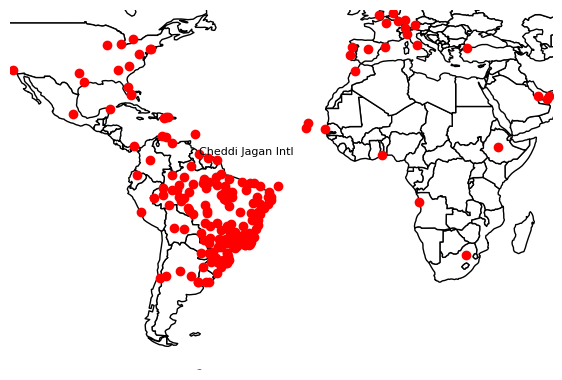

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

world.plot(ax=ax, color='white', edgecolor='black')

ax.plot(df_airports.lon, df_airports.lat, marker='o', lw=0, color='r')

xmin, xmax = df_airports.lon.min(), df_airports.lon.max()
ymin, ymax = df_airports.lat.min(), df_airports.lat.max()

ymin = df_airports[df_airports.country == "Guiana"].lon.min()

ax.set_xlim(xmin-1, xmax+1)
ax.set_ylim(ymin-5, ymax+1)

for row in df_airports.iterrows():
    if row[1].country == "Guiana":
        ax.text(row[1].lon, row[1].lat, row[1].city, fontsize=8)

ax.set_axis_off()

plt.savefig("tex/figs/corrigido_guiana.pdf")
plt.show()

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


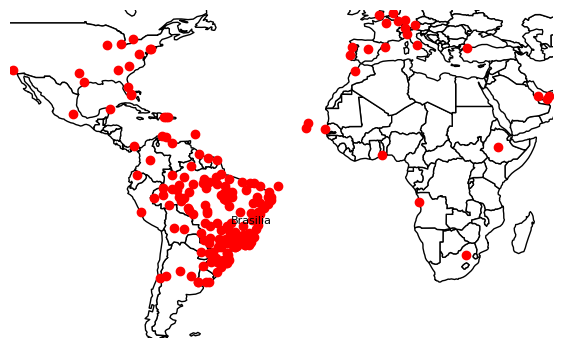

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

world.plot(ax=ax, color='white', edgecolor='black')

ax.plot(df_airports.lon, df_airports.lat, marker='o', lw=0, color='r')

xmin, xmax = df_airports.lon.min(), df_airports.lon.max()
ymin, ymax = df_airports.lat.min(), df_airports.lat.max()

ymin = df_airports[df_airports.city == "Brasilia"].lon.min()

ax.set_xlim(xmin-1, xmax+1)
ax.set_ylim(ymin-5, ymax+1)

for row in df_airports.iterrows():
    if row[1].city == "Brasilia":
        ax.text(row[1].lon, row[1].lat, row[1].city, fontsize=8)

ax.set_axis_off()
plt.show()

# Questão 1


## Item a e b


In [90]:
recife_id = df_airports[df_airports.city == "Recife"].iloc[0].id

natal_id = df_airports[df_airports.city == "Natal"].iloc[0].id
paris_id = df_airports[df_airports.city == "Paris"].iloc[0].id


print("Recife e Natal tiveram voos = {}".format(g.are_neighbours(recife_id, natal_id)))
print("Recife e Paris tiveram voos = {}".format(g.are_neighbours(recife_id, paris_id)))




Recife e Natal tiveram voos = True
Recife e Paris tiveram voos = False


/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


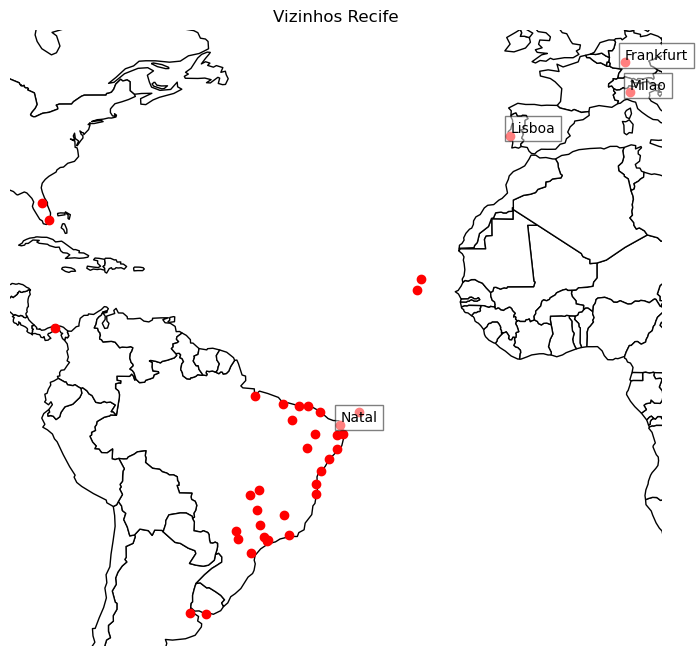

In [91]:
# Plot the world map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='white', edgecolor='k')

recife_adjs = g.adj[recife_id]
adjs_filter = df_airports.id.isin(g.adj[recife_id])
ax.plot(df_airports.lon[adjs_filter], df_airports.lat[adjs_filter], marker='o', lw=0, color='r')

# Customize the plot (optional)
ax.set_title(r"Vizinhos Recife")
ax.set_axis_off()

for id_air in recife_adjs:
    row = df_airports[df_airports.id == id_air].iloc[0]
    if row["city"] in ["Recife", "Natal", "Paris", "Frankfurt", "Milao", "Lisboa"]:
        ax.text(row.lon, row.lat, row["city"], va="bottom", ha="left", bbox=dict(facecolor="w",alpha=0.5))

xmin, xmax = df_airports[adjs_filter].lon.min(), df_airports[adjs_filter].lon.max()
ymin, ymax = df_airports[adjs_filter].lat.min(), df_airports[adjs_filter].lat.max()
ax.set_xlim(xmin-5, xmax+5)
ax.set_ylim(ymin-5, ymax+5)

plt.savefig("tex/figs/vizinhos_recife.pdf")
plt.show()

## Item c

In [92]:
santos_dumont_id = df_airports[df_airports.city == "Rio De Janeiro"].iloc[1].id
galeao_id = df_airports[df_airports.city == "Rio De Janeiro"].iloc[0].id
df_airports[df_airports.city == "Rio De Janeiro"]

,index,name,country,city,lat,lon,id
8,Aeroporto Internacional Do Rio De Janeiro/Galeao,Aeroporto Internacional Do Rio De Janeiro/Galeao,Brasil,Rio De Janeiro,-22.813410,-43.249423,8
76,Santos Dumont,Santos Dumont,Brasil,Rio De Janeiro,-22.911144,-43.164876,76


In [112]:
santos_dumont_adjs = set(g.adj[santos_dumont_id])
galeao_adjs = set(g.adj[galeao_id])

print(len(galeao_adjs))

rio_adjs = santos_dumont_adjs.union(galeao_adjs)

print(santos_dumont_adjs - galeao_adjs)

print("Cidades que só o Santos Dumont tem voo:")
for city in (santos_dumont_adjs - galeao_adjs):
    print("\t", df_airports[df_airports.id == city].iloc[0]["city"])


cidades = set([df_airports[df_airports.id == r].iloc[0]["city"] for r in rio_adjs])
cidades = list(cidades)
cidades.sort()
print(len(cidades))
print(cidades)

65
{184, 123}
Cidades que só o Santos Dumont tem voo:
	 Sao Jose Dos Campos
	 Uberlandia
66
['Amsterdam', 'Aracaju', 'Atlanta/Intl', 'Bayeux', 'Belem', 'Belo Horizonte', 'Bogota', 'Brasilia', 'Buenos Aires', 'Campina Grande', 'Campinas', 'Campo Grande', 'Campos Dos Goytacazes', 'Casablanca', 'Charlotte Douglas Intl', 'Confins', 'Cordoba', 'Dallas/Fort Worth', 'Dubai International', 'Florianopolis', 'Fortaleza', 'Foz Do Iguacu', 'Frankfurt', 'Goiania', 'Guarulhos', 'Houston', 'Ilheus', 'Lima', 'Lisboa', 'Londres', 'Luanda', 'Macae', 'Madrid', 'Manaus', 'Mexico', 'Miami', 'Montevideu', 'Natal', 'Navegantes', 'New York', 'Orlando', 'Panama', 'Paris', 'Porto', 'Porto Alegre', 'Porto Seguro', 'Punta Cana', 'Recife', 'Ribeirao Preto', 'Rio Largo', 'Roma', 'Rosario', 'Salvador', 'Santiago Do Chile', 'Sao Domingo/De Las Americas', 'Sao Jose Dos Campos', 'Sao Jose Dos Pinhais', 'Sao Luis', 'Sao Paulo', 'Teresina', 'Toronto', 'Uberlandia', 'Varzea Grande', 'Vitoria', 'Washington/Dulles Intl', 'Z

In [94]:
df_airports[df_airports.city.str.contains("Buenos")]

,index,name,country,city,lat,lon,id
14,Buenos Aires,Buenos Aires,Argentina,Buenos Aires,-34.815004,-58.534828,14
15,Buenos Aires/Aeroparque,Buenos Aires/Aeroparque,Argentina,Buenos Aires,-34.816662,-58.536759,15


In [95]:
# Print a latex table with of cidades with flights from Rio de Janeiro with 12 columns



## Item d



In [96]:
guarulhos_id = df_airports[df_airports.city=="Guarulhos"].iloc[0]["id"]
print(guarulhos_id)

1


In [114]:
guarulhos_adj_names = set()
for adj in g.adj[guarulhos_id]:
    city_name = df_airports[df_airports.id == adj].iloc[0]["city"]
    guarulhos_adj_names.add(city_name)

guarulhos_adj_names = list(guarulhos_adj_names)
guarulhos_adj_names.sort()

print(guarulhos_adj_names)

len(guarulhos_adj_names)

['Ab Dhabi International', 'Addis Ababa', 'Amsterdam', 'Aracaju', 'Arealva', 'Aruba', 'Assuncao', 'Atlanta/Intl', 'Barcelona', 'Bayeux', 'Belem', 'Belo Horizonte', 'Bogota', 'Bonito', 'Brasilia', 'Bridgetown/Grantley Adams', 'Buenos Aires', 'Campina Grande', 'Campo Grande', 'Cancun/Intl', 'Caracas/Intl', 'Casablanca', 'Cascavel', 'Chapeco', 'Chicago', 'Cidade Del Este', 'Cochabamba', 'Confins', 'Cordoba', 'Dacar', 'Dallas/Fort Worth', 'Detroit', 'Doha', 'Dourados', 'Dubai International', 'Florianopolis', 'Fortaleza', 'Foz Do Iguacu', 'Frankfurt', 'Goiana', 'Goiania', 'Houston', 'Ilheus', 'Istanbul/Ataturk', 'Johannesburg', 'Joinville', 'Juazeiro Do Norte', 'La Romana', 'Lima', 'Lisboa', 'Lome', 'Londres', 'Londrina', 'Los Angeles', 'Luanda', 'Luxemburgo', 'Madrid', 'Maldonado-Uruguai', 'Manaus', 'Maringa', 'Mendoza', 'Mexico', 'Miami', 'Milao', 'Montes Claros', 'Montevideu', 'Munchen', 'Natal', 'Navegantes', 'New York', 'Newark / Intl Nj', 'Orlando', 'Panama', 'Paris', 'Passo Fundo', '

106

In [98]:
g.adj[0]

[1]

In [116]:
adj_max = []
for id, adj in enumerate(g.adj):
    name = df_airports[df_airports.id == id].iloc[0]["name"]
    city = df_airports[df_airports.id == id].iloc[0]["city"]
    names = set()
    for adj_id in adj:
        adj_name = df_airports[df_airports.id == adj_id].iloc[0]["city"]
        names.add(adj_name)
    adj_max.append((len(names), city, name))

adj_max.sort(reverse=True)

# Print latex table with the top 10 airports with most neighbors
print("\\begin{tabular}{|c|c|c|}")
print("\\hline")
print("Posição & Cidade & Aeroporto & Vizinhos \\\\")
print("\\hline")
for i in range(10):
    print("{} & {} & {} & {} \\\\".format(i+1, adj_max[i][1], adj_max[i][2], adj_max[i][0]))
    print("\\hline")
print("\\end{tabular}")


\begin{tabular}{|c|c|c|}
\hline
Posição & Cidade & Aeroporto & Vizinhos \\
\hline
1 & Guarulhos & Guarulhos - Governador Andre Franco Montoro & 106 \\
\hline
2 & Campinas & Viracopos & 72 \\
\hline
3 & Rio De Janeiro & Aeroporto Internacional Do Rio De Janeiro/Galeao & 64 \\
\hline
4 & Brasilia & Presidente Juscelino Kubitschek & 59 \\
\hline
5 & Confins & Tancredo Neves & 55 \\
\hline
6 & Recife & Guararapes - Gilberto Freyre & 39 \\
\hline
7 & Sao Paulo & Congonhas & 37 \\
\hline
8 & Salvador & Deputado Luis Eduardo Magalhaes & 32 \\
\hline
9 & Porto Alegre & Salgado Filho & 31 \\
\hline
10 & Manaus & Eduardo Gomes & 30 \\
\hline
\end{tabular}


In [117]:
adj_max_city = defaultdict(lambda: {"city": "", "adj": set()})
for id, adj in enumerate(g.adj):
    name = df_airports[df_airports.id == id].iloc[0]["name"]
    city = df_airports[df_airports.id == id].iloc[0]["city"]
    adj_max_city[city]["city"] = city
    adj_max_city[city]["adj"] = adj_max_city[city]["adj"] | set(adj)


adj_max_list = set()
for city, adj in adj_max_city.items():
    city_names = set()
    for adj_id in adj["adj"]:
        adj_name = df_airports[df_airports.id == adj_id].iloc[0]["city"]
        city_names.add(adj_name)
    adj_max_list.add((len(city_names), adj["city"]))

adj_max_list = list(adj_max_list)
adj_max_list.sort(reverse=True)

# Print latex table with the top 10 cities with most neighbors
print("\\begin{tabular}{|c|c|}")
print("\\hline")
print("Posição & Cidade & Vizinhos \\\\")
print("\\hline")
for i in range(10):
    print("{} & {} & {} \\\\".format(i+1, adj_max_list[i][1], adj_max_list[i][0]))
    print("\\hline")
print("\\end{tabular}")



\begin{tabular}{|c|c|}
\hline
Posição & Cidade & Vizinhos \\
\hline
1 & Guarulhos & 106 \\
\hline
2 & Campinas & 72 \\
\hline
3 & Rio De Janeiro & 66 \\
\hline
4 & Brasilia & 59 \\
\hline
5 & Confins & 55 \\
\hline
6 & Recife & 39 \\
\hline
7 & Sao Paulo & 37 \\
\hline
8 & Salvador & 32 \\
\hline
9 & Porto Alegre & 31 \\
\hline
10 & Manaus & 30 \\
\hline
\end{tabular}


# Questão 3

## Item a

In [101]:
fernando_noronha_id = df_airports[df_airports.city == "Fernando De Noronha"].iloc[0].id
brasilia_id = df_airports[df_airports.city == "Brasilia"].iloc[0]["id"]


In [102]:
import os
os.makedirs("tex/figs/paths", exist_ok=True)

marcado_dfs, visit_order_dfs = g.dfs(fernando_noronha_id)
marcado_bfs, aresta_final, visit_order_bfs = g.bfs(fernando_noronha_id)

x_min, x_max = df_airports.lon.min(), df_airports.lon.max()
y_min, y_max = df_airports.lat.min(), df_airports.lat.max()

fig, axs = plt.subplots(2, 1)
for ax in axs.flat:
    world.plot(ax=ax, color='white', edgecolor='black')
    ax.plot(df_airports.lon, df_airports.lat, marker='o', lw=0, color='b')
    ax.set_axis_off()
    ax.set_xlim(x_min-1, x_max+1)
    ax.set_ylim(y_min-1, y_max+1)

axs[0].set_title("DFS")
axs[1].set_title("BFS")

for i in range(1,len(visit_order_dfs)):
    plt.suptitle(f"Step = {i}")
    axs[0].plot(df_airports.lon[visit_order_dfs[:i]], df_airports.lat[visit_order_dfs[:i]], marker='o', lw=0, color='r')
    axs[1].plot(df_airports.lon[visit_order_bfs[:i]], df_airports.lat[visit_order_bfs[:i]], marker='o', lw=0, color='r')
    # save png with i with 3 digits 
    if i == 1:
        plt.tight_layout()
    plt.savefig("tex/figs/paths/path_{:03d}.png".format(i))

plt.close()

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


## Item b


In [103]:
df_airports[(df_airports.city == "Roma") | (df_airports.city =="Fernando De Noronha")]

,index,name,country,city,lat,lon,id
56,Roma,Roma,Italia,Roma,41.799053,12.592979,56
147,Fernando De Noronha,Fernando De Noronha,Brasil,Fernando De Noronha,-3.854614,-32.424385,147


In [104]:
roma_id = df_airports[df_airports.city == "Roma"].iloc[0].id
fernando_noronha_id = df_airports[df_airports.city == "Fernando De Noronha"].iloc[0].id
print(f"Roma = {roma_id} and Fernando De Noronha = {fernando_noronha_id}")

Roma = 56 and Fernando De Noronha = 147


In [105]:
marcado, caminho, _ = g.bfs(roma_id)
roma_to_fernando = g.build_path(caminho, fernando_noronha_id)

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


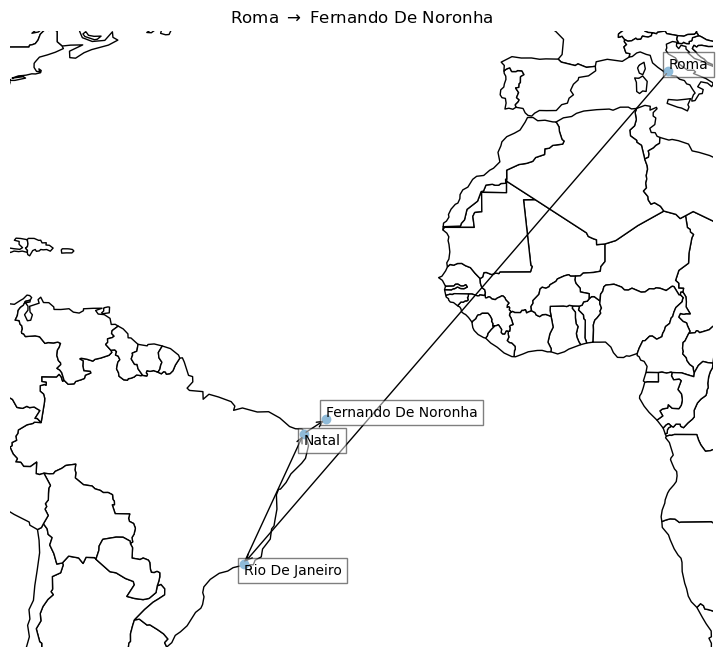

In [106]:
# Plot the world map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='white', edgecolor='k')
xs, ys, names = plot_path(roma_to_fernando, df_airports, ax)


# Customize the plot (optional)
ax.set_title(r"Roma $\rightarrow$ Fernando De Noronha")
ax.set_axis_off()

xmin, ymin, _,_ = world[world.name == "Brazil"].geometry.iloc[0].bounds
_, _, xmax,ymax = world[world.name == "Italy"].geometry.iloc[0].bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.savefig("./tex/figs/roma_fernando_noronha.pdf", bbox_inches='tight', pad_inches=0)

for i in range(len(xs)):
    if i == 0:
        ax.text(xs[i], ys[i], names[i], va="bottom", ha="left", bbox=dict(facecolor="w",alpha=0.5))
    elif i == 3:
        ax.text(xs[i], ys[i], names[i], va="bottom", ha="left", bbox=dict(facecolor="w",alpha=0.5))
    else:
        ax.text(xs[i], ys[i], names[i], va="top", ha="left", bbox=dict(facecolor="w",alpha=0.5))

plt.savefig("./tex/figs/roma_fernando_noronha_names.pdf", bbox_inches='tight', pad_inches=0)

# Display the plot
plt.show()

## Item c

In [107]:
def build_complete_graph(n):
    g = Graph(n)
    for i in range(n-1):
        for j in range(i+1, n):
            g.add_edge(i, j, check=False)
    return g

def random_graph(n, n_edges):
    g = Graph(n)
    edges = set()
    while len(edges) < n_edges:
        i = np.random.randint(0, n)
        j = np.random.randint(0, n)
        if i != j:
            edges.add((i, j))
    for i, j in edges:
        g.add_edge(i, j, check=False)
    return g

In [119]:
data = []

for n in [10, 100, 1000, 1000, 10000]:
    for i in range(3):
        print("Running n = {} i = {}".format(n, i))
        g = build_complete_graph(n)

        # Measure time of bfs
        current_run = {"n": n, "type": "bfs", "m": n*(n-1)//2, "graph_type": "complete" }
        start = time.time()
        marcado, caminho, _ = g.bfs(0)
        end = time.time()
        elapsed = end - start
        current_run["time"] = elapsed
        data.append(current_run)

        current_run = {"n": n, "type": "dfs", "m": n*(n-1)//2, "graph_type": "complete" }
        start = time.time()
        marcado, caminho  = g.dfs(0)
        end = time.time()
        elapsed = end - start
        current_run["time"] = elapsed
        data.append(current_run)

        del g

for n in [10, 100, 1000, 10000, 100000, 1000000]:
    m_funcs = [lambda n: n//10, lambda n: int(sqrt(n)), lambda n: n]
    m_names = ["n/10", "sqrt(n)", "n"]
    for m_name, m_func in zip(m_names, m_funcs):
        m = m_func(n)
        for i in range(3):
            print("Running n = {} i = {}".format(n, i))
            g = random_graph(n, m)
            # Measure time of bfs
            current_run = {"n": n, "type": "bfs", "m": m, "graph_type": m_name }
            start = time.time()
            marcado, caminho, _ = g.bfs(0)
            end = time.time()
            elapsed = end - start
            current_run["time"] = elapsed
            data.append(current_run)

            current_run = {"n": n, "type": "dfs", "m": m, "graph_type": m_name }
            start = time.time()
            marcado, caminho  = g.dfs(0)
            end = time.time()
            elapsed = end - start
            current_run["time"] = elapsed
            data.append(current_run)
            

            del g

df_time = pd.DataFrame(data)

Running n = 10 i = 0
Running n = 10 i = 1
Running n = 10 i = 2
Running n = 100 i = 0
Running n = 100 i = 1
Running n = 100 i = 2
Running n = 1000 i = 0
Running n = 1000 i = 1
Running n = 1000 i = 2
Running n = 1000 i = 0
Running n = 1000 i = 1
Running n = 1000 i = 2
Running n = 10000 i = 0
Running n = 10000 i = 1
Running n = 10000 i = 2
Running n = 10 i = 0
Running n = 10 i = 1
Running n = 10 i = 2
Running n = 10 i = 0
Running n = 10 i = 1
Running n = 10 i = 2
Running n = 10 i = 0
Running n = 10 i = 1
Running n = 10 i = 2
Running n = 100 i = 0
Running n = 100 i = 1
Running n = 100 i = 2
Running n = 100 i = 0
Running n = 100 i = 1
Running n = 100 i = 2
Running n = 100 i = 0
Running n = 100 i = 1
Running n = 100 i = 2
Running n = 1000 i = 0
Running n = 1000 i = 1
Running n = 1000 i = 2
Running n = 1000 i = 0
Running n = 1000 i = 1
Running n = 1000 i = 2
Running n = 1000 i = 0
Running n = 1000 i = 1
Running n = 1000 i = 2
Running n = 10000 i = 0
Running n = 10000 i = 1
Running n = 10000 i

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

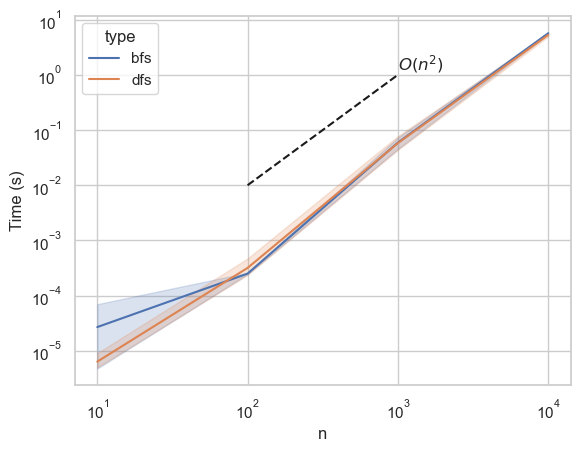

In [126]:
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x="n", y="time", hue="type", data=df_time[df_time.graph_type == "complete"])

# Add O(n2) line 
ax.plot([100, 1000], [1/100, 1], color='k', ls="--", label="$O(n^2)$")
ax.text(1000, 1, "$O(n^2)$", va="bottom", ha="left")

# Set x scale to log
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Time (s)")

plt.savefig("tex/figs/time_complete_graph.pdf")
plt.show()

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

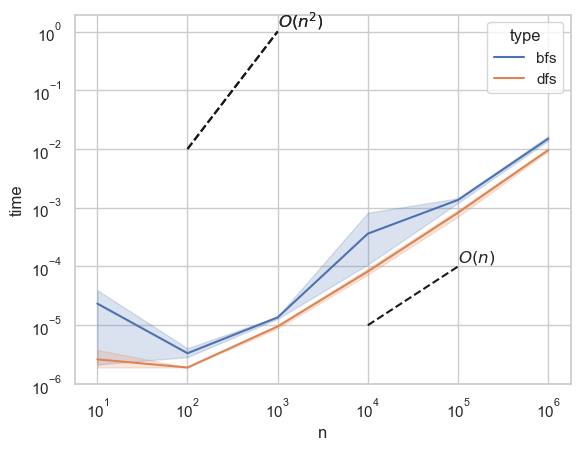

In [124]:
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x="n", y="time", hue="type", data=df_time[df_time.graph_type == "sqrt(n)"])

# Add O(n2) line 
ax.plot([100, 1000], [1/100, 1], color='k', ls="--", label="$O(n^2)$")
ax.text(1000, 1, "$O(n^2)$", va="bottom", ha="left")

ax.plot([100, 1000], [1/100, 1], color='k', ls="--", label="$O(n^2)$")
ax.text(1000, 1, "$O(n^2)$", va="bottom", ha="left")

ax.plot([10000, 100000], [1/100000, 1/10000], color='k', ls="--", label="$O(n^2)$")
ax.text(100000, 1/10000, "$O(n)$", va="bottom", ha="left")

# Set x scale to log
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel("Time (s)")